In [1]:
#%% Importando os pacotes necessários
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import plotly.io as pio
pio.renderers.default = 'browser'
import plotly.graph_objects as go

In [2]:
# Importando o banco de dados
perfil = pd.read_excel("/Users/administrador/Documents/usp_ds_analytics/usp_ds_analytics/anacor_mca/data/perfil_aplicacao.xlsx")

In [3]:
# Informações descritivas sobre as variáveis
print(perfil['Perfil'].value_counts())
print(perfil['Tipo de Aplicação'].value_counts())

Perfil
Agressivo      58
Moderado       25
Conservador    17
Name: count, dtype: int64
Tipo de Aplicação
Ações       45
CDB         40
Poupança    15
Name: count, dtype: int64


### Criando a tabela de contingência

In [4]:
tabela = pd.crosstab(perfil["Perfil"], perfil["Tipo de Aplicação"])
print(tabela)

Tipo de Aplicação  Ações  CDB  Poupança
Perfil                                 
Agressivo             36   20         2
Conservador            5    4         8
Moderado               4   16         5


### Analisando a significância estatística da associação (teste qui²)

In [5]:
teste_qui2 = chi2_contingency(tabela)

print(f"estatística qui²: {round(teste_qui2[0], 2)}")
print(f"p-valor da estatística: {round(teste_qui2[1], 4)}")
print(f"graus de liberdade: {teste_qui2[2]}")

estatística qui²: 31.76
p-valor da estatística: 0.0
graus de liberdade: 4


Como teste de hipótese, eu posso olhar direto para o p-value da estatística. Ele mostra se é estatisticamente significativo e se podemos rejeitar H0 (não existe associação significativa entre as variáveis).

O teste chi2 apenas mostra se existe uma associação, porém ainda não sabemos de onde vem essa associação, quais categorias envolvem isso. 

### Análise dos resíduos provenientes da tabela de contingência.
Esta etapa não é obrigatória, mas vamos fazer esta análise para compreender a aula.

In [6]:
# Parametrizando a função
tab_cont = sm.stats.Table(tabela)

# Tabela de frequências absolutas esperadas
print("Tabela de frequências absolutas esperadas")
print(tab_cont.fittedvalues)
print("")
# Tabela de resíduos: diferença entre freq. absolutas observadas e esperadas
print("Tabela de resíduos")
print(tabela - tab_cont.fittedvalues)
print("")
# Valores qui-quadrado por célula
print("Valores qui-quadrado")
print(tab_cont.chi2_contribs)
print("")

Tabela de frequências absolutas esperadas
Tipo de Aplicação  Ações   CDB  Poupança
Perfil                                  
Agressivo          26.10  23.2      8.70
Conservador         7.65   6.8      2.55
Moderado           11.25  10.0      3.75

Tabela de resíduos
Tipo de Aplicação  Ações  CDB  Poupança
Perfil                                 
Agressivo           9.90 -3.2     -6.70
Conservador        -2.65 -2.8      5.45
Moderado           -7.25  6.0      1.25

Valores qui-quadrado
Tipo de Aplicação     Ações       CDB   Poupança
Perfil                                          
Agressivo          3.755172  0.441379   5.159770
Conservador        0.917974  1.152941  11.648039
Moderado           4.672222  3.600000   0.416667



In [7]:
# Resíduos padronizados
print("Resíduos padronizados")
print(tab_cont.resid_pearson)
print("")
# Resíduos padronizados ajustados
print("Resíduos padronizados ajustados")
print(tab_cont.standardized_resids)

Resíduos padronizados
Tipo de Aplicação     Ações       CDB  Poupança
Perfil                                         
Agressivo          1.937827 -0.664364 -2.271513
Conservador       -0.958110 -1.073751  3.412922
Moderado          -2.161532  1.897367  0.645497

Resíduos padronizados ajustados
Tipo de Aplicação     Ações       CDB  Poupança
Perfil                                         
Agressivo          4.031893 -1.323444 -3.801728
Conservador       -1.418061 -1.521559  4.063291
Moderado          -3.365501  2.828427  0.808452


### Mapa de calor dos resíduos padronizados ajustados

In [8]:
fig = go.Figure()

maxz = np.max(tab_cont.standardized_resids)+0.1
minz = np.min(tab_cont.standardized_resids)-0.1

colorscale = ['skyblue' if i>1.96 else '#FAF9F6' for i in np.arange(minz,maxz,0.01)]

fig.add_trace(
    go.Heatmap(
        x = tab_cont.standardized_resids.columns,
        y = tab_cont.standardized_resids.index,
        z = np.array(tab_cont.standardized_resids),
        text=tab_cont.standardized_resids.values,
        texttemplate='%{text:.2f}',
        showscale=False,
        colorscale=colorscale))

fig.update_layout(
    title='Resíduos Padronizados Ajustados',
    height = 600,
    width = 600)

fig.show()

## Elaborando a ANACOR

In [9]:
# Na função, o input é a tabela de contingência criada antes!
ca = prince.CA().fit(tabela)

### Obtendo os eigenvalues (autovalores)

In [10]:
tabela_autovalores = ca.eigenvalues_summary
print(tabela_autovalores)
# São gerados 'm' autovalores: m = mín(I-1,J-1)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.233        73.42%                     73.42%
1              0.084        26.58%                    100.00%


Os eigenvalues representam as inércias parciais de cada dimensão.

- Eixo X: 0 (73.42% )
- Eixo Y: 1 (26.58%)

O primeiro autovalor é sempre maior que os demais.

### Obtendo a inércia principal total

In [11]:
# É a soma dos eigenvalues (também é a divisão: estat. qui² / N)
# Quanto maior a inércia principal total, maior é a associação entre categorias
print(ca.total_inertia_)

0.3176416497633535


### Massas das categorias

In [12]:
# Massas da variável em linha
print(ca.row_masses_)

# Massas da variável em coluna
print("")
print(ca.col_masses_)

Agressivo      0.58
Conservador    0.17
Moderado       0.25
dtype: float64

Ações       0.45
CDB         0.40
Poupança    0.15
dtype: float64


### Autovetores
Servem de base para a geração das coordenadas x, y das categorias em linha e das categorias em coluna

In [13]:
# Autovetor linha
print(ca.svd_.U)

# Autovetor coluna
print("")
print(ca.svd_.V.T)

[[-0.62491193 -0.17171219]
 [ 0.67162481 -0.61556487]
 [ 0.39800149  0.76915201]]

[[-0.56215025 -0.48372213]
 [ 0.09300977  0.76899232]
 [ 0.82178847 -0.41792789]]


- O primeiro representa a primeira dimensão, eixo X
- O segundo representa a segunda dimensão, eixo Y

### Obtendo as coordenadas do mapa perceptual

In [14]:
# Coordenadas da variável em linha
print(ca.row_coordinates(tabela))

# Coordenadas da variável em coluna
print(ca.column_coordinates(tabela))

                    0         1
Perfil                         
Agressivo   -0.396262 -0.065513
Conservador  0.786648 -0.433800
Moderado     0.384408  0.446974
                          0         1
Tipo de Aplicação                    
Ações             -0.404692 -0.209522
CDB                0.071019  0.353291
Poupança           1.024690 -0.313542


### Plotando o mapa percentual da Anacor

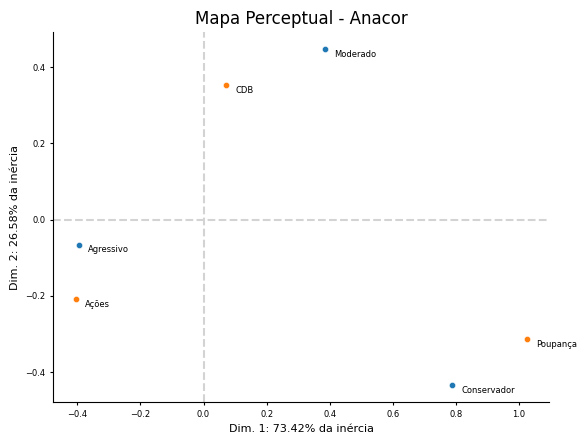

In [15]:
# Criado um chart para coordenadas linha e outro para coluna
chart_df_row = pd.DataFrame({'var_row': tabela.index,
                             'x_row':ca.row_coordinates(tabela)[0].values,
                             'y_row': ca.row_coordinates(tabela)[1].values})

chart_df_col = pd.DataFrame({'var_col': tabela.columns,
                             'x_col':ca.column_coordinates(tabela)[0].values,
                             'y_col': ca.column_coordinates(tabela)[1].values})

# Definição dos labels para o gráfico
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=6)

label_point(x = chart_df_col['x_col'],
            y = chart_df_col['y_col'],
            val = chart_df_col['var_col'],
            ax = plt.gca())

label_point(x = chart_df_row['x_row'],
            y = chart_df_row['y_row'],
            val = chart_df_row['var_row'],
            ax = plt.gca()) 

# Scatterplot com formatação
sns.scatterplot(data=chart_df_row, x='x_row', y='y_row', s=20)
sns.scatterplot(data=chart_df_col, x='x_col', y='y_col', s=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--')
plt.axvline(x=0, color='lightgrey', ls='--')
plt.tick_params(size=2, labelsize=6)
plt.title("Mapa Perceptual - Anacor", fontsize=12)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=8)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=8)
plt.show()

Categorias que estão próximas, são aquelas que estão associadas.
É uma análise por proximidade.

### Obtendo as coordenadas das observações

In [18]:
# Identificando as variáveis em linha e em coluna
# Com base no que aprendi lá acima, sobre as coordenadas do mapa perceptual
coord_obs = perfil.rename(columns={'Perfil':'var_row',
                                   'Tipo de Aplicação':'var_col'})

# Unindo as coordenadas das categorias ao DataFrame
coord_obs = pd.merge(coord_obs, chart_df_row, how='left', on='var_row')
coord_obs = pd.merge(coord_obs, chart_df_col, how='left', on='var_col')

# Calculando as coordenadas médias das observações (média de suas categorias)
coord_obs['x_obs'] = coord_obs[['x_row','x_col']].mean(axis=1)
coord_obs['y_obs'] = coord_obs[['y_row','y_col']].mean(axis=1)

### Plotando o mapa percentual das observações da Anacor

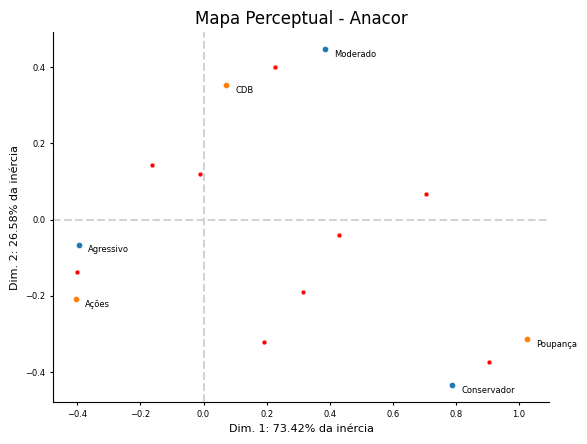

In [17]:
chart_df_row = pd.DataFrame({'var_row': tabela.index,
                             'x_row':ca.row_coordinates(tabela)[0].values,
                             'y_row': ca.row_coordinates(tabela)[1].values})

chart_df_col = pd.DataFrame({'var_col': tabela.columns,
                             'x_col':ca.column_coordinates(tabela)[0].values,
                             'y_col': ca.column_coordinates(tabela)[1].values})

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=6)

label_point(x = chart_df_col['x_col'],
            y = chart_df_col['y_col'],
            val = chart_df_col['var_col'],
            ax = plt.gca())

label_point(x = chart_df_row['x_row'],
            y = chart_df_row['y_row'],
            val = chart_df_row['var_row'],
            ax = plt.gca()) 

sns.scatterplot(data=chart_df_row, x='x_row', y='y_row', s=20)
sns.scatterplot(data=chart_df_col, x='x_col', y='y_col', s=20)
sns.scatterplot(data=coord_obs, x='x_obs', y='y_obs', s=10, color='red')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--')
plt.axvline(x=0, color='lightgrey', ls='--')
plt.tick_params(size=2, labelsize=6)
plt.title("Mapa Perceptual - Anacor", fontsize=12)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=8)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=8)
plt.show()

Nós partimos de variáveis categóricas para variáveis métricas (posição x, y), sem pmderação arbitrária!